In [1]:
%run get_data.ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import simfin as sf

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.pipeline import make_pipeline

import matplotlib.ticker as ticker

## Load Merged Dataframes

In [2]:
df_merged_qrt_all = pd.read_csv('merged quarterly data.csv', index_col=[0])

In [3]:
df_merged_qrt_all

,Ticker,Report Date,Close,Return QOQ,Moveup QOQ,Sector,Industry,Report Y-M,(Dividends + Share Buyback) / FCF,Asset Turnover,...,x0_Business Services,x0_Consumer Cyclical,x0_Consumer Defensive,x0_Energy,x0_Financial Services,x0_Healthcare,x0_Industrials,x0_Real Estate,x0_Technology,x0_Utilities
0,A,2011-07-30,42.16,-0.120731,0,Healthcare,Medical Diagnostics & Research,2011-07,0.168927,0.711759,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,A,2011-10-31,37.07,0.145670,1,Healthcare,Medical Diagnostics & Research,2011-10,0.185950,0.738375,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,A,2012-01-31,42.47,-0.006828,0,Healthcare,Medical Diagnostics & Research,2012-01,0.177064,0.730374,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,A,2012-04-30,42.18,-0.094832,0,Healthcare,Medical Diagnostics & Research,2012-04,0.045863,0.739752,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,A,2012-07-30,38.18,-0.057360,0,Healthcare,Medical Diagnostics & Research,2012-07,0.162579,0.721024,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,low,2019-02-28,105.09,-0.125797,0,Consumer Cyclical,Retail - Apparel & Specialty,2019-02,0.728218,1.938196,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45168,low,2019-05-28,91.87,0.221291,1,Consumer Cyclical,Retail - Apparel & Specialty,2019-05,0.859274,2.066448,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45169,low,2019-08-31,112.20,0.045544,1,Consumer Cyclical,Retail - Apparel & Specialty,2019-08,1.170789,1.658761,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45170,low,2019-11-30,117.31,-0.091552,0,Consumer Cyclical,Retail - Apparel & Specialty,2019-11,1.838699,1.764197,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Predicting QOQ stock movements using financial signals and macro indicators

In [4]:
with open('S&P 500 tickers.txt', 'r') as file:
    sp500_tickers = file.readlines()
sp500_tickers = [x.strip() for x in sp500_tickers]
print('Total stocks in S&P 500 index:   ', len(sp500_tickers))

Total stocks in S&P 500 index:    505


In [5]:
df_tweets = pd.read_csv('tweets_textblob.txt', delimiter="\t", header=0)
df_tweets['sentiment M-1 (textblob)'] = df_tweets.groupby(['company'])['sentiment'].transform(lambda x: x.shift(1))
df_tweets = df_tweets.drop(columns=['sentiment','date']).dropna()
print('Textblob shape:', df_tweets.shape)

tickers_intersection = set(df_tweets.company).intersection(sp500_tickers)
print(len(tickers_intersection))

df_merged_qrt = df_merged_qrt_all[df_merged_qrt_all.Ticker.isin(list(tickers_intersection))]
df_merged_qrt = pd.merge(df_merged_qrt, 
                         df_tweets, 
                         left_on=['Ticker','Report Y-M'], 
                         right_on=['company', 'time'], how='inner').drop(columns=['company','time'])



Textblob shape: (60916, 3)
487


In [6]:
df_merged_qrt

,Ticker,Report Date,Close,Return QOQ,Moveup QOQ,Sector,Industry,Report Y-M,(Dividends + Share Buyback) / FCF,Asset Turnover,...,x0_Consumer Cyclical,x0_Consumer Defensive,x0_Energy,x0_Financial Services,x0_Healthcare,x0_Industrials,x0_Real Estate,x0_Technology,x0_Utilities,sentiment M-1 (textblob)
0,A,2011-07-30,42.16,-0.120731,0,Healthcare,Medical Diagnostics & Research,2011-07,0.168927,0.711759,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.126510
1,A,2011-10-31,37.07,0.145670,1,Healthcare,Medical Diagnostics & Research,2011-10,0.185950,0.738375,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.159080
2,A,2012-01-31,42.47,-0.006828,0,Healthcare,Medical Diagnostics & Research,2012-01,0.177064,0.730374,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.196739
3,A,2012-04-30,42.18,-0.094832,0,Healthcare,Medical Diagnostics & Research,2012-04,0.045863,0.739752,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.133496
4,A,2012-07-30,38.18,-0.057360,0,Healthcare,Medical Diagnostics & Research,2012-07,0.162579,0.721024,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.177405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12719,ZTS,2019-03-31,100.67,0.127347,1,Healthcare,Drug Manufacturers,2019-03,0.624005,0.540503,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.298158
12720,ZTS,2019-06-30,113.49,0.097806,1,Healthcare,Drug Manufacturers,2019-06,0.616107,0.543416,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.273853
12721,ZTS,2019-09-30,124.59,0.061161,1,Healthcare,Drug Manufacturers,2019-09,0.576439,0.550337,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.272421
12722,ZTS,2019-12-30,132.21,-0.109825,0,Healthcare,Drug Manufacturers,2019-12,0.624564,0.545600,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.235058


In [7]:
features = \
['(Dividends + Share Buyback) / FCF',
'Asset Turnover', 'CapEx / (Depr + Amor)', 'Current Ratio',
'Debt Ratio', 'Dividends / FCF', 'Dummy_Dividends',
'Gross Profit Margin', 'Interest Coverage', 'Inventory Turnover',
'Log Revenue', 'Net Profit Margin', 'Quick Ratio', 'Return on Assets',
'Return on Equity', 'Share Buyback / FCF', 'Assets Growth',
'Assets Growth QOQ', 'Assets Growth YOY', 'Earnings Growth',
'Earnings Growth QOQ', 'Earnings Growth YOY', 'FCF Growth',
'FCF Growth QOQ', 'FCF Growth YOY', 'Sales Growth', 'Sales Growth QOQ',
'Sales Growth YOY', 'Unemployment Rate', 'Unemployment Rate Growth MOM',
'Unemployment Rate Growth QOQ', 'Unemployment Rate Growth YOY', 'CPI',
'CPI Growth MOM', 'CPI Growth QOQ', 'CPI Growth YOY', 'IPI',
'IPI Growth MOM', 'IPI Growth QOQ', 'IPI Growth YOY',
'New Housing Permits', 'New Housing Permits Growth MOM',
'New Housing Permits Growth QOQ', 'New Housing Permits Growth YOY',
'Consumer Sentiment', 'Consumer Sentiment Growth MOM',
'Consumer Sentiment Growth QOQ', 'Consumer Sentiment Growth YOY',
'Real GDP Growth QOQ', 'Real GDP Growth YOY', 'M2 Growth MOM',
'M2 Growth QOQ', 'M2 Growth YOY', 'x0_Basic Materials',
'x0_Business Services', 'x0_Consumer Cyclical', 'x0_Consumer Defensive',
'x0_Energy', 'x0_Financial Services', 'x0_Healthcare', 'x0_Industrials',
'x0_Real Estate', 'x0_Technology', 'x0_Utilities',
'sentiment M-1 (textblob)']

### Split the data into train and test sets

In [8]:
df_merged_qrt = df_merged_qrt[df_merged_qrt['Report Y-M'] >= '2011-01']
df_train = df_merged_qrt[df_merged_qrt['Report Y-M'] < '2018-01']
df_test = df_merged_qrt[df_merged_qrt['Report Y-M'] >= '2018-01']

train = df_train[features].reset_index(drop=True)
y_train_ret = df_train['Return QOQ'].reset_index(drop=True)
y_train_mov = df_train['Moveup QOQ'].reset_index(drop=True)

test = df_test[features].reset_index(drop=True)
y_test_ret = df_test['Return QOQ'].reset_index(drop=True)
y_test_mov = df_test['Moveup QOQ'].reset_index(drop=True)


print('X train:', train.shape)
print('y train:', y_train_ret.shape)
print()


print('X test:', test.shape)
print('y test:', y_test_ret.shape)

X train: (9125, 65)
y train: (9125,)

X test: (3435, 65)
y test: (3435,)


In [9]:
df_merged_qrt

,Ticker,Report Date,Close,Return QOQ,Moveup QOQ,Sector,Industry,Report Y-M,(Dividends + Share Buyback) / FCF,Asset Turnover,...,x0_Consumer Cyclical,x0_Consumer Defensive,x0_Energy,x0_Financial Services,x0_Healthcare,x0_Industrials,x0_Real Estate,x0_Technology,x0_Utilities,sentiment M-1 (textblob)
0,A,2011-07-30,42.16,-0.120731,0,Healthcare,Medical Diagnostics & Research,2011-07,0.168927,0.711759,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.126510
1,A,2011-10-31,37.07,0.145670,1,Healthcare,Medical Diagnostics & Research,2011-10,0.185950,0.738375,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.159080
2,A,2012-01-31,42.47,-0.006828,0,Healthcare,Medical Diagnostics & Research,2012-01,0.177064,0.730374,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.196739
3,A,2012-04-30,42.18,-0.094832,0,Healthcare,Medical Diagnostics & Research,2012-04,0.045863,0.739752,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.133496
4,A,2012-07-30,38.18,-0.057360,0,Healthcare,Medical Diagnostics & Research,2012-07,0.162579,0.721024,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.177405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12719,ZTS,2019-03-31,100.67,0.127347,1,Healthcare,Drug Manufacturers,2019-03,0.624005,0.540503,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.298158
12720,ZTS,2019-06-30,113.49,0.097806,1,Healthcare,Drug Manufacturers,2019-06,0.616107,0.543416,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.273853
12721,ZTS,2019-09-30,124.59,0.061161,1,Healthcare,Drug Manufacturers,2019-09,0.576439,0.550337,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.272421
12722,ZTS,2019-12-30,132.21,-0.109825,0,Healthcare,Drug Manufacturers,2019-12,0.624564,0.545600,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.235058


### Base (Passive Investment)

In [10]:
# As the base, we will conduct the passive investing and hold all shares in the S&P 500 index
print('Baseline score (train set): {:.4f}'.format(sum(y_train_mov == 1) / len(y_train_mov)))

Baseline score (train set): 0.6293


### Define a Cross-Validation Strategy

In [11]:
def precision_cv(n_folds, model, X, y):
    kf = KFold(n_folds, shuffle=False).get_n_splits(X.values)
    scores = cross_validate(model, X, y, cv=kf, scoring='precision', return_train_score=True, n_jobs=-1)
    return scores['train_score'], scores['test_score']

### Logistic Classifier: 
- RobustScaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [12]:
log_l2 = make_pipeline(RobustScaler(), LogisticRegression(max_iter=1000, penalty='l2', tol=0.001, solver='newton-cg'))
train_scores, val_scores = precision_cv(5, log_l2, train, y_train_mov)
print("\nLogist with L2 train score: {:.4f} ({:.4f}); validation score: {:.4f} ({:.4f})\n".format(train_scores.mean(), train_scores.std(),
                                                                                            val_scores.mean(), val_scores.std()))


Logist with L2 train score: 0.6981 (0.0020); validation score: 0.6928 (0.0043)



### Support Vector Machine

In [13]:
svm = make_pipeline(RobustScaler(), SVC(gamma='auto'))
train_scores, val_scores = precision_cv(5, svm, train, y_train_mov)
print("\nSVM train score: {:.4f} ({:.4f}); validation score: {:.4f} ({:.4f})\n".format(train_scores.mean(), train_scores.std(),
                                                                                 val_scores.mean(), val_scores.std()))



SVM train score: 0.7889 (0.0021); validation score: 0.6622 (0.0053)



In [14]:
svm = make_pipeline(RobustScaler(), SVC(kernel='sigmoid'))
train_scores, val_scores = precision_cv(5, svm, train, y_train_mov)
print("\nSVM train score: {:.4f} ({:.4f}); validation score: {:.4f} ({:.4f})\n".format(train_scores.mean(), train_scores.std(),
                                                                                 val_scores.mean(), val_scores.std()))



SVM train score: 0.6293 (0.0001); validation score: 0.6293 (0.0003)



In [15]:
svm = make_pipeline(RobustScaler(), SVC(kernel='poly'))
train_scores, val_scores = precision_cv(5, svm, train, y_train_mov)
print("\nSVM train score: {:.4f} ({:.4f}); validation score: {:.4f} ({:.4f})\n".format(train_scores.mean(), train_scores.std(),
                                                                                 val_scores.mean(), val_scores.std()))



SVM train score: 0.6293 (0.0001); validation score: 0.6292 (0.0002)



### K-Nearest Neighbor (KNN) Classifier: 

In [17]:
knn_train = []
knn_val = []
for n in range(1,10):
    neigh = KNeighborsClassifier(n_neighbors=n)
    train_scores, val_scores = precision_cv(5, neigh, train, y_train_mov)
    knn_train.append((train_scores.mean(), train_scores.std()))
    knn_val.append((val_scores.mean(), val_scores.std()))
    print("\nKNN (n=" + str(n) +") train score: {:.4f} ({:.4f}); validation score: {:.4f} ({:.4f})\n".format(train_scores.mean(), train_scores.std(),
                                                                                                       val_scores.mean(), val_scores.std()))


KNN (n=1) train score: 1.0000 (0.0000); validation score: 0.6859 (0.0079)


KNN (n=2) train score: 1.0000 (0.0000); validation score: 0.7219 (0.0125)


KNN (n=3) train score: 0.8220 (0.0032); validation score: 0.6948 (0.0056)


KNN (n=4) train score: 0.8568 (0.0041); validation score: 0.7169 (0.0090)


KNN (n=5) train score: 0.7742 (0.0045); validation score: 0.6998 (0.0085)


KNN (n=6) train score: 0.8002 (0.0036); validation score: 0.7134 (0.0093)


KNN (n=7) train score: 0.7555 (0.0044); validation score: 0.7015 (0.0074)


KNN (n=8) train score: 0.7762 (0.0042); validation score: 0.7133 (0.0064)


KNN (n=9) train score: 0.7413 (0.0041); validation score: 0.6996 (0.0068)



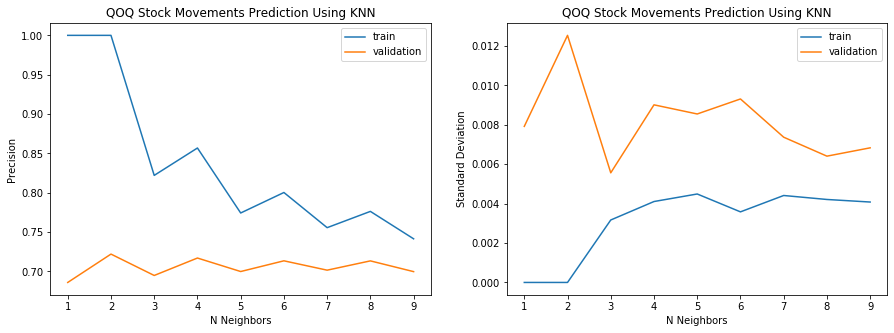

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(range(1,10), [x[0] for x in knn_train], figure=fig, label='train')
ax1.plot(range(1,10), [x[0] for x in knn_val], figure=fig, label='validation')
ax1.set_xlabel('N Neighbors')
ax1.set_ylabel('Precision')
ax1.set_title('QOQ Stock Movements Prediction Using KNN')
ax1.legend()

ax2.plot(range(1,10), [x[1] for x in knn_train], figure=fig, label='train')
ax2.plot(range(1,10), [x[1] for x in knn_val], figure=fig, label='validation')
ax2.set_xlabel('N Neighbors')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('QOQ Stock Movements Prediction Using KNN')
ax2.legend()

### Random Forest: 

In [19]:
rf_train = []
rf_val = []
depths = range(1, 41)
for depth in depths:
    rf = RandomForestClassifier(max_depth=depth, n_estimators=10, random_state=1)
    train_scores, val_scores = precision_cv(5, rf, train, y_train_mov)
    rf_train.append((train_scores.mean(), train_scores.std()))
    rf_val.append((val_scores.mean(), val_scores.std()))
    print("\nRandom Forest (max_depth=" + str(depth) +") train score: {:.4f} ({:.4f}); validation score: {:.4f} ({:.4f})\n".format(train_scores.mean(), train_scores.std(),
                                                                                                                               val_scores.mean(), val_scores.std()))


Random Forest (max_depth=1) train score: 0.6370 (0.0053); validation score: 0.6357 (0.0048)


Random Forest (max_depth=2) train score: 0.6617 (0.0031); validation score: 0.6606 (0.0038)


Random Forest (max_depth=3) train score: 0.6662 (0.0035); validation score: 0.6649 (0.0048)


Random Forest (max_depth=4) train score: 0.6800 (0.0036); validation score: 0.6729 (0.0018)


Random Forest (max_depth=5) train score: 0.6859 (0.0026); validation score: 0.6767 (0.0026)


Random Forest (max_depth=6) train score: 0.7059 (0.0034); validation score: 0.6906 (0.0032)


Random Forest (max_depth=7) train score: 0.7225 (0.0019); validation score: 0.6929 (0.0031)


Random Forest (max_depth=8) train score: 0.7430 (0.0059); validation score: 0.7011 (0.0021)


Random Forest (max_depth=9) train score: 0.7638 (0.0025); validation score: 0.7049 (0.0080)


Random Forest (max_depth=10) train score: 0.7877 (0.0047); validation score: 0.7073 (0.0064)


Random Forest (max_depth=11) train score: 0.8109 (0.0077);

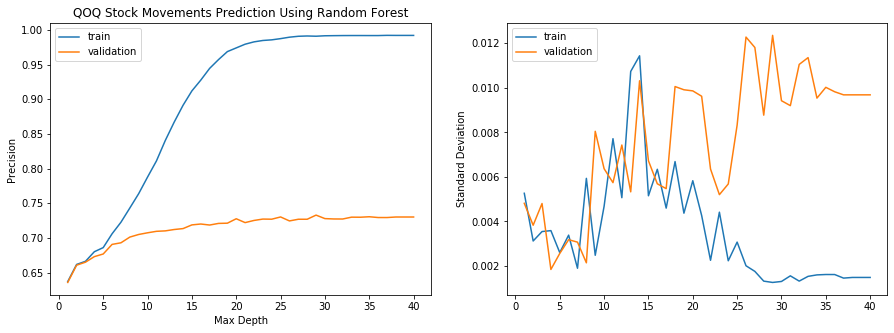

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(depths, [x[0] for x in rf_train], figure=fig, label='train')
ax1.plot(depths, [x[0] for x in rf_val], figure=fig, label='validation')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('Precision')
ax1.set_title('QOQ Stock Movements Prediction Using Random Forest')
ax1.legend()

ax2.plot(depths, [x[1] for x in rf_train], figure=fig, label='train')
ax2.plot(depths, [x[1] for x in rf_val], figure=fig, label='validation')
ax1.set_xlabel('Max Depth')
ax2.set_ylabel('Standard Deviation')
ax1.set_title('QOQ Stock Movements Prediction Using Random Forest')
ax2.legend()

### Gradient Boosting Classifier:

In [21]:
gb_train = []
gb_val = []
depths = range(1, 21)
for depth in depths:
    GBoost = GradientBoostingClassifier(max_depth=depth, random_state=0, n_estimators=10)
    train_scores, val_scores = precision_cv(5, GBoost, train, y_train_mov)
    gb_train.append((train_scores.mean(), train_scores.std()))
    gb_val.append((val_scores.mean(), val_scores.std()))
    print("\nGBoost (max_depth=" + str(depth) +") train score: {:.4f} ({:.4f}); validation score: {:.4f} ({:.4f})\n".format(train_scores.mean(), train_scores.std(),
                                                                                                                               val_scores.mean(), val_scores.std()))


GBoost (max_depth=1) train score: 0.6438 (0.0049); validation score: 0.6429 (0.0042)


GBoost (max_depth=2) train score: 0.6534 (0.0004); validation score: 0.6530 (0.0017)


GBoost (max_depth=3) train score: 0.6607 (0.0041); validation score: 0.6569 (0.0044)


GBoost (max_depth=4) train score: 0.6740 (0.0050); validation score: 0.6651 (0.0049)


GBoost (max_depth=5) train score: 0.6854 (0.0061); validation score: 0.6705 (0.0059)


GBoost (max_depth=6) train score: 0.7018 (0.0111); validation score: 0.6776 (0.0080)


GBoost (max_depth=7) train score: 0.7193 (0.0083); validation score: 0.6830 (0.0099)


GBoost (max_depth=8) train score: 0.7456 (0.0082); validation score: 0.6883 (0.0082)


GBoost (max_depth=9) train score: 0.7814 (0.0083); validation score: 0.6928 (0.0090)


GBoost (max_depth=10) train score: 0.8202 (0.0110); validation score: 0.6940 (0.0063)


GBoost (max_depth=11) train score: 0.8596 (0.0154); validation score: 0.6953 (0.0090)


GBoost (max_depth=12) train score: 0.900

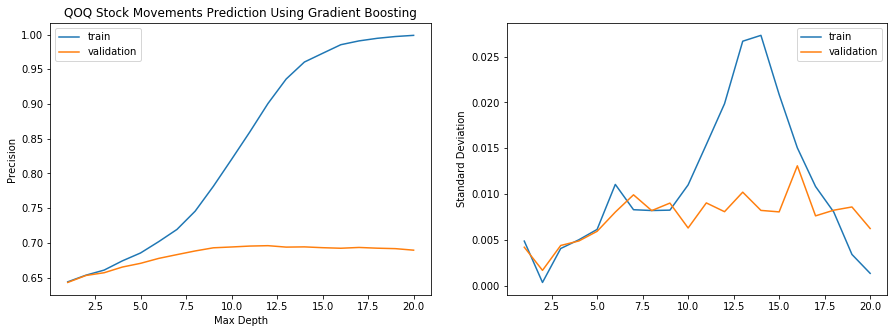

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.plot(depths, [x[0] for x in gb_train], figure=fig, label='train')
ax1.plot(depths, [x[0] for x in gb_val], figure=fig, label='validation')
ax1.set_xlabel('Max Depth')
ax1.set_ylabel('Precision')
ax1.set_title('QOQ Stock Movements Prediction Using Gradient Boosting')
ax1.legend()

ax2.plot(depths, [x[1] for x in gb_train], figure=fig, label='train')
ax2.plot(depths, [x[1] for x in gb_val], figure=fig, label='validation')
ax1.set_xlabel('Max Depth')
ax2.set_ylabel('Standard Deviation')
ax1.set_title('QOQ Stock Movements Prediction Using Gradient Boosting')
ax2.legend()

### Back Testing: random forest with max depth = 25

### On test set

In [23]:
rf = RandomForestClassifier(max_depth=25, random_state=0, n_estimators=100, n_jobs=-1)
rf.fit(train, y_train_mov)

rf_basic = RandomForestClassifier(max_depth=25, random_state=0, n_estimators=100, n_jobs=-1)
rf_basic.fit(train.iloc[:,:-1], y_train_mov)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [24]:
risk_free_interest_rate = 0.03

In [25]:
thresholds = []
precisions = []
returns = []
volatilities = []
sharpe_ratios = []
holdings = []
for threshold in np.arange(0.5, 1.01, 0.01):
    y_pred = (pd.DataFrame(rf.predict_proba(test)).iloc[:,1] > threshold).astype(int)
    precision = precision_score(y_true=y_test_mov, y_pred=y_pred)
    return_qrt = y_test_ret[y_pred == 1].mean()
    std_qrt = y_test_ret[y_pred == 1].std()
    if sum(y_pred == 1) > 100:
        thresholds.append(threshold)
        precisions.append(precision*100)
        returns.append(return_qrt*4*100)
        volatilities.append(std_qrt*2*100)
        sharpe_ratios.append((return_qrt*4 - risk_free_interest_rate/100)/(std_qrt*2))
        holdings.append(sum(y_pred == 1))
    else:
        break

In [26]:
df_thresholds = pd.DataFrame({'Threshold': thresholds,
                             'Precision': precisions,
                             'Annualized Return': returns,
                             'Annualized Volatility': volatilities,
                             'Annualized Sharpe Ratio': sharpe_ratios,
                             'Number of Holding Stocks': holdings})
df_thresholds

,Threshold,Precision,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Number of Holding Stocks
0,0.50,57.710805,5.139269,36.950716,0.138273,3119
1,0.51,57.726524,5.229655,37.141229,0.139997,3035
2,0.52,57.755999,5.176901,37.283141,0.138049,2959
3,0.53,57.498248,4.788373,37.465508,0.127007,2854
4,0.54,57.623400,5.004246,37.745925,0.131782,2735
5,0.55,57.661135,4.999060,37.887891,0.131152,2591
6,0.56,57.535934,5.177303,38.078430,0.135176,2435
7,0.57,57.352288,4.755195,38.280856,0.123435,2251
8,0.58,57.252274,4.847760,38.646338,0.124663,2089
9,0.59,57.450157,5.745853,38.916539,0.146875,1906


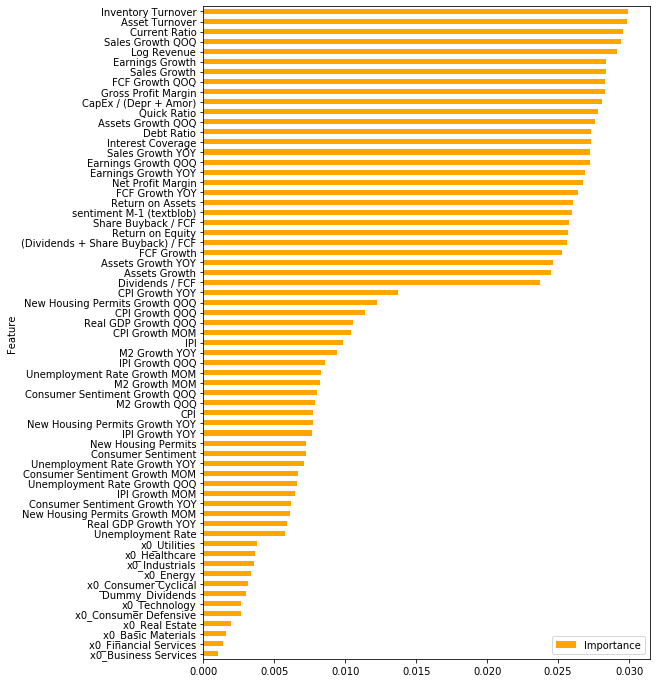

In [27]:
# Show importance of the featuresa
importance_frame = pd.DataFrame({'Importance': list(rf.feature_importances_), 'Feature': list(train.columns)})
importance_frame.sort_values(by='Importance', inplace=True)
importance_frame.plot(kind='barh', x='Feature', figsize=(8, 12), color='orange')

In [28]:
# baseline
base_precision = precision_score(y_true=y_test_mov, y_pred=np.ones(len(test)))*100
base_return = y_test_ret.mean()*4*100
base_volatility = y_test_ret.std()*2*100
base_sharpe_ratio = (base_return - risk_free_interest_rate)/(base_volatility)
print("precision: {:.4f} return: {:.4f} volatility: {:.4f} sharpe_ratio: {:.4f}".format(base_precision, base_return, base_volatility, base_sharpe_ratio))
print(len(test))

precision: 57.9039 return: 5.1989 volatility: 36.2732 sharpe_ratio: 0.1425
3435


In [29]:
thresholds = []
precisions = []
returns = []
volatilities = []
sharpe_ratios = []
holdings = []
for threshold in np.arange(0.5, 1.01, 0.01):
    y_pred = (pd.DataFrame(rf_basic.predict_proba(test.iloc[:,:-1])).iloc[:,1] > threshold).astype(int)
    precision = precision_score(y_true=y_test_mov, y_pred=y_pred)
    return_qrt = y_test_ret[y_pred == 1].mean()
    std_qrt = y_test_ret[y_pred == 1].std()
    if sum(y_pred == 1) > 100:
        thresholds.append(threshold)
        precisions.append(precision*100)
        returns.append(return_qrt*4*100)
        volatilities.append(std_qrt*2*100)
        sharpe_ratios.append((return_qrt*4 - risk_free_interest_rate/100)/(std_qrt*2))
        holdings.append(sum(y_pred == 1))
    else:
        break
        
df_thresholds_basic = pd.DataFrame({'Threshold': thresholds,
                             'Precision': precisions,
                             'Annualized Return': returns,
                             'Annualized Volatility': volatilities,
                             'Annualized Sharpe Ratio': sharpe_ratios,
                             'Number of Holding Stocks': holdings})
df_thresholds_basic

,Threshold,Precision,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Number of Holding Stocks
0,0.50,57.533355,5.691083,36.919878,0.153334,3073
1,0.51,57.488247,5.866174,37.054734,0.157501,2978
2,0.52,57.331940,5.739445,37.155799,0.153662,2871
3,0.53,57.768053,6.494955,37.112405,0.174199,2742
4,0.54,57.729191,6.990987,37.207591,0.187085,2607
5,0.55,57.690755,7.566485,36.947338,0.203979,2477
6,0.56,58.110440,7.784966,36.680590,0.211419,2318
7,0.57,58.058523,8.692292,36.516425,0.237216,2153
8,0.58,58.906883,9.882455,36.872997,0.267200,1976
9,0.59,58.490566,8.896525,37.207610,0.238299,1802


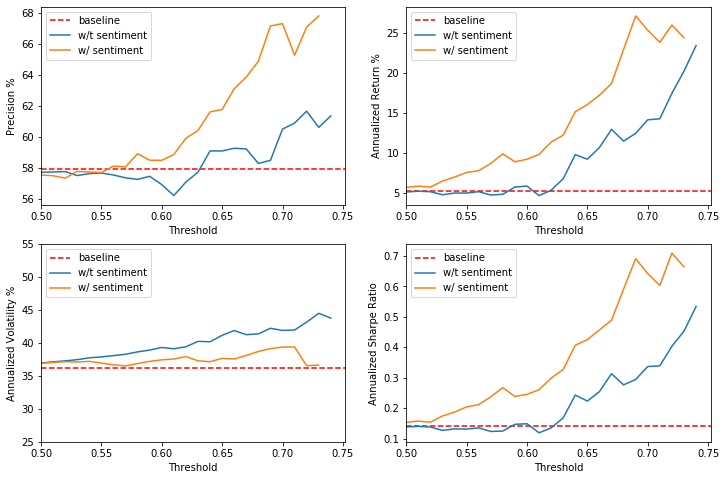

In [30]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0,0].axhline(y=base_precision, color='r', label='baseline', linestyle='--')
axs[0,0].plot(df_thresholds['Threshold'], df_thresholds['Precision'], label='w/t sentiment')
axs[0,0].plot(df_thresholds_basic['Threshold'], df_thresholds_basic['Precision'], label='w/ sentiment')
axs[0,0].set_ylabel('Precision %')
axs[0,0].set_xlabel('Threshold')

axs[0,1].axhline(y=base_return, color='r', label='baseline', linestyle='--')
axs[0,1].plot(df_thresholds['Threshold'], df_thresholds['Annualized Return'],label='w/t sentiment')
axs[0,1].plot(df_thresholds_basic['Threshold'], df_thresholds_basic['Annualized Return'], label='w/ sentiment')
axs[0,1].set_ylabel('Annualized Return %')
axs[0,1].set_xlabel('Threshold')

axs[1,0].axhline(y=base_volatility, color='r', label='baseline', linestyle='--')
axs[1,0].plot(df_thresholds['Threshold'], df_thresholds['Annualized Volatility'], label='w/t sentiment')
axs[1,0].plot(df_thresholds_basic['Threshold'], df_thresholds_basic['Annualized Volatility'], label='w/ sentiment')
axs[1,0].set_ylabel('Annualized Volatility %')
axs[1,0].set_xlabel('Threshold')
axs[1,0].set_ylim((25,55))

axs[1,1].axhline(y=base_sharpe_ratio, color='r', label='baseline', linestyle='--')
axs[1,1].plot(df_thresholds['Threshold'], df_thresholds['Annualized Sharpe Ratio'], label='w/t sentiment')
axs[1,1].plot(df_thresholds_basic['Threshold'], df_thresholds_basic['Annualized Sharpe Ratio'], label='w/ sentiment')
axs[1,1].set_ylabel('Annualized Sharpe Ratio')
axs[1,1].set_xlabel('Threshold')

for row in axs:
    for ax in row:
        ax.legend(loc='upper left')
        ax.set_xlim((0.5))

In [31]:
df_merged_prob = df_test.copy()
df_merged_prob['Prob'] = [float(x[1]) for x in rf.predict_proba(test)]
df_merged_prob= df_merged_prob.sort_values(by='Report Y-M')

print(df_merged_prob['Report Y-M'].iloc[0], df_merged_prob['Report Y-M'].iloc[-1])

from datetime import datetime
datetimes = pd.DataFrame({'Date':pd.date_range(start='2018-01', end='2020-07', freq='M')})
datetimes['Date'] = datetimes['Date'].transform(lambda x: '-'.join(str(x).split('-')[:-1]))

2018-01 2020-03


30 30


Text(0.5, 1.0, 'Portfolio Performance using Random Forest')

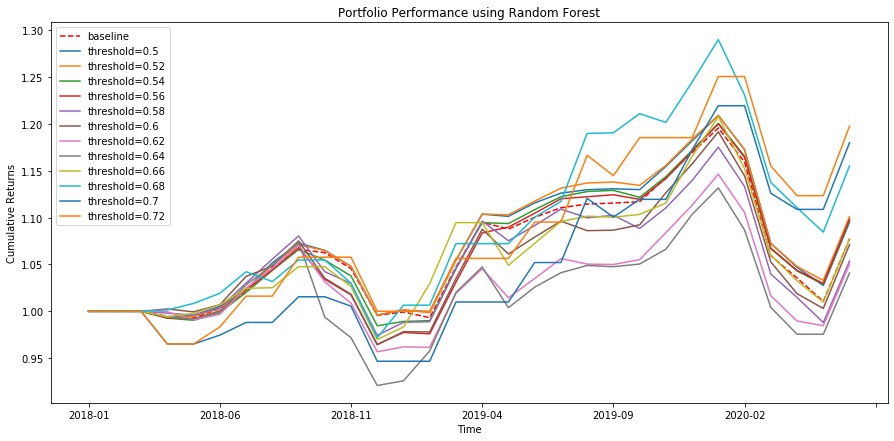

In [32]:
group_1 = df_merged_prob[[x.split('-')[1] in ['01', '04', '07', '10'] for x in df_merged_prob['Report Y-M']]].reset_index(drop=True)
group_2 = df_merged_prob[[x.split('-')[1] in ['02', '05', '08', '11'] for x in df_merged_prob['Report Y-M']]].reset_index(drop=True)
group_3 = df_merged_prob[[x.split('-')[1] in ['03', '06', '09', '12'] for x in df_merged_prob['Report Y-M']]].reset_index(drop=True)

fig, ax = plt.subplots(1,1, figsize=(15,7))

#baseline
df_1 = group_1.groupby('Report Y-M').mean()
df_1 = pd.merge(left = datetimes, right = df_1[['Return QOQ', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)

df_2 = group_2.groupby('Report Y-M').mean()
df_2 = pd.merge(left = datetimes, right = df_2[['Return QOQ', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)

df_3 = group_3.groupby('Report Y-M').mean()
df_3 = pd.merge(left = datetimes, right = df_3[['Return QOQ', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)

_y = [1,1,1]
_y.extend([1+x for x in pd.concat([df_1, df_2, df_3],axis=1)[['Return QOQ']].mean(axis=1)][:-3])
print(len(datetimes), len(_y))
ax.plot(datetimes['Date'],
        np.cumprod(_y), 
        label='baseline', color='r', linestyle='--')


for threshold in np.arange(thresholds[0], thresholds[-1]+0.001, 0.02):
    # Average portfolio return in the quarter
    df_1 = group_1[group_1['Prob'] > threshold].groupby('Report Y-M').mean()
    df_1 = pd.merge(left = datetimes, right = df_1[['Return QOQ', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)
    
    df_2 = group_2[group_2['Prob'] > threshold].groupby('Report Y-M').mean()
    df_2 = pd.merge(left = datetimes, right = df_2[['Return QOQ', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)
    
    df_3 = group_3[group_3['Prob'] > threshold].groupby('Report Y-M').mean()
    df_3 = pd.merge(left = datetimes, right = df_3[['Return QOQ', 'Prob']],
                      left_on='Date', right_index=True, how = 'left').fillna(0)
    
    _y = [1,1,1]
    _y.extend([1+x for x in pd.concat([df_1, df_2, df_3],axis=1)[['Return QOQ']].mean(axis=1)][:-3])
    
    ax.plot(datetimes['Date'],
            np.cumprod(_y), 
            label='threshold='+str(round(threshold,2)))

ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Cumulative Returns')
ax.set_title('Portfolio Performance using Random Forest')